# Project 2 – Machine Learning Modeling and Pipeline (MVP)
## Predicting Flight Status Using Operational, Holiday, and Passenger Traffic Data

This notebook presents the Minimum Viable Project (MVP) implementation for Project 2.
The goal is to build an end-to-end machine learning pipeline that predicts flight
status outcomes (On-Time, Delayed, Cancelled) before departure.

### Business Context
Flight delays and cancellations create operational inefficiencies and financial losses
for airlines. Predictive modeling enables early-warning signals for proactive scheduling
and passenger communication.

### Methodology
This project follows the CRISP-DM framework:
1. Business Understanding  
2. Data Understanding  
3. Data Preparation  
4. Modeling  
5. Evaluation  

This MVP emphasizes robustness, clarity, and reproducibility.

In [1]:
# ==========================================
# Import required libraries
# ==========================================

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Display settings
pd.set_option("display.max_columns", 100)
plt.style.use("ggplot")
sns.set()

## 1) Business Understanding (CRISP-DM)

**Objective:** Predict flight status (On-Time, Delayed, Cancelled) before departure
to support proactive airline operational decisions.

## 2) Data Understanding (CRISP-DM)

Load all datasets, inspect schema, assess data quality, and examine the target distribution.

In [2]:
# ===============================
# Load datasets
# ===============================

air = pd.read_csv("Airline Dataset Updated - v2.csv")
hol = pd.read_csv("global_holidays.csv")
traf = pd.read_csv("monthly_passengers.csv")

print("Airline shape:", air.shape)
print("Holidays shape:", hol.shape)
print("Traffic shape:", traf.shape)

air.head()

Airline shape: (98619, 15)
Holidays shape: (44393, 5)
Traffic shape: (7242, 7)


,Passenger ID,First Name,Last Name,Gender,Age,Nationality,Airport Name,Airport Country Code,Country Name,Airport Continent,Continents,Departure Date,Arrival Airport,Pilot Name,Flight Status
0,ABVWIg,Edithe,Leggis,Female,62,Japan,Coldfoot Airport,US,United States,NAM,North America,6/28/2022,CXF,Fransisco Hazeldine,On Time
1,jkXXAX,Elwood,Catt,Male,62,Nicaragua,Kugluktuk Airport,CA,Canada,NAM,North America,12/26/2022,YCO,Marla Parsonage,On Time
2,CdUz2g,Darby,Felgate,Male,67,Russia,Grenoble-Isère Airport,FR,France,EU,Europe,1/18/2022,GNB,Rhonda Amber,On Time
3,BRS38V,Dominica,Pyle,Female,71,China,Ottawa / Gatineau Airport,CA,Canada,NAM,North America,9/16/2022,YND,Kacie Commucci,Delayed
4,9kvTLo,Bay,Pencost,Male,21,China,Gillespie Field,US,United States,NAM,North America,2/25/2022,SEE,Ebonee Tree,On Time


In [3]:
# ===============================
# Basic data inspection
# ===============================

print("=== Airline Dataset Info ===")
air.info()

print("\n=== Flight Status Distribution ===")
print(air["Flight Status"].value_counts(dropna=False))


=== Airline Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98619 entries, 0 to 98618
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Passenger ID          98619 non-null  object
 1   First Name            98619 non-null  object
 2   Last Name             98619 non-null  object
 3   Gender                98619 non-null  object
 4   Age                   98619 non-null  int64 
 5   Nationality           98619 non-null  object
 6   Airport Name          98619 non-null  object
 7   Airport Country Code  98619 non-null  object
 8   Country Name          98619 non-null  object
 9   Airport Continent     98619 non-null  object
 10  Continents            98619 non-null  object
 11  Departure Date        98619 non-null  object
 12  Arrival Airport       98619 non-null  object
 13  Pilot Name            98619 non-null  object
 14  Flight Status         98619 non-null  object
dtypes: int6

## 3) Data Preparation (CRISP-DM)

Clean data, standardize date fields, and engineer robust holiday and traffic features.

In [4]:
# ==========================================
# Airline data preparation
# ==========================================

# Convert departure date to datetime format
air["DepartureDate"] = pd.to_datetime(
    air["Departure Date"], errors="coerce"
)

# Create ISO3 country code for dataset merging
air["ISO3"] = air["Airport Country Code"]

# Convert Age to numeric
air["Age"] = pd.to_numeric(air["Age"], errors="coerce")

# Remove rows without a target label
air = air.dropna(subset=["Flight Status"])

# Extract month and day for feature engineering
air["DepMonth"] = air["DepartureDate"].dt.month
air["DepDay"] = air["DepartureDate"].dt.day

print("Prepared airline shape:", air.shape)


Prepared airline shape: (98619, 19)


### Holiday Feature Engineering

Holidays are treated as recurring annual events and matched using
(country, month, day) to avoid year misalignment.

In [5]:
# ==========================================
# Holiday feature engineering
# ==========================================

# Convert holiday dates to datetime
hol["Date"] = pd.to_datetime(hol["Date"], errors="coerce")

# Extract month and day
hol["HolidayMonth"] = hol["Date"].dt.month
hol["HolidayDay"] = hol["Date"].dt.day

# Create a recurring holiday lookup table
holiday_base = hol[
    ["ISO3", "HolidayMonth", "HolidayDay", "Type"]
].drop_duplicates()

# Merge airline data with holidays
df = air.merge(
    holiday_base,
    left_on=["ISO3", "DepMonth", "DepDay"],
    right_on=["ISO3", "HolidayMonth", "HolidayDay"],
    how="left"
)

# Create holiday indicators
df["is_holiday"] = df["Type"].notna().astype(int)
df["holiday_type"] = df["Type"].fillna("None")

### Passenger Traffic Feature Engineering

Create a seasonal congestion index using historical passenger traffic averages.

In [6]:
# ==========================================
# Passenger traffic feature engineering
# ==========================================

# Ensure correct data types
traf["Month"] = pd.to_numeric(traf["Month"], errors="coerce")
traf["Total"] = pd.to_numeric(traf["Total"], errors="coerce")

# Compute average monthly passengers per country
seasonal = (
    traf.groupby(["ISO3", "Month"], as_index=False)["Total"]
        .mean()
        .rename(columns={"Total": "AvgMonthlyPassengers"})
)

# Normalize to create congestion index
seasonal["CountryMean"] = seasonal.groupby("ISO3")[
    "AvgMonthlyPassengers"
].transform("mean")

seasonal["traffic_congestion_index"] = (
    seasonal["AvgMonthlyPassengers"] / seasonal["CountryMean"]
)

seasonal = seasonal.drop(columns="CountryMean")

# Merge congestion index into main dataset
df = df.merge(
    seasonal[["ISO3", "Month", "traffic_congestion_index"]],
    left_on=["ISO3", "DepMonth"],
    right_on=["ISO3", "Month"],
    how="left"
)

# Fill missing congestion values with neutral level
df["traffic_congestion_index"] = df[
    "traffic_congestion_index"
].fillna(1.0)

In [7]:
# ==========================================
# Handle remaining missing values
# ==========================================

df["Age"] = df["Age"].fillna(df["Age"].median())

## 4) Modeling (CRISP-DM)

Train a baseline model and a more advanced model using a reproducible pipeline.

In [8]:
# ==========================================
# Feature selection
# ==========================================

target_col = "Flight Status"

numeric_features = ["Age", "traffic_congestion_index"]
categorical_features = [
    "Gender",
    "Nationality",
    "Airport Continent",
    "Continents",
    "holiday_type"
]

# Feature matrix and target vector
X = df[numeric_features + categorical_features].copy()
y = df[target_col].copy()

# Fill missing categorical values
for col in categorical_features:
    X[col] = X[col].fillna("Unknown")

# Ensure numeric stability
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")
    X[col] = X[col].fillna(X[col].median())

In [9]:
# ==========================================
# Train-test split
# ==========================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [10]:
# ==========================================
# Preprocessing pipeline
# ==========================================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

### Baseline Model: Logistic Regression

In [11]:
from sklearn.preprocessing import StandardScaler

# ==========================================
# Baseline model: Logistic Regression (Improved)
# - Scale numeric features to help optimization
# - Use 'saga' solver (works well with sparse one-hot data)
# - Increase max_iter to reduce convergence warnings
# ==========================================

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_lr),
    ("model", LogisticRegression(
        max_iter=5000,
        solver="saga",
        n_jobs=-1,
        random_state=42
    ))
])

# Fit baseline model
logreg_pipeline.fit(X_train, y_train)

# Test-set evaluation
y_pred_lr = logreg_pipeline.predict(X_test)

print("=== Logistic Regression (Improved Baseline) ===")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression (Improved Baseline) ===
              precision    recall  f1-score   support

   Cancelled       0.32      0.34      0.33      6589
     Delayed       0.33      0.31      0.32      6566
     On Time       0.33      0.32      0.33      6569

    accuracy                           0.33     19724
   macro avg       0.33      0.33      0.33     19724
weighted avg       0.33      0.33      0.33     19724



In [12]:
# ==========================================
# Cross-validation for Logistic Regression
# ==========================================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_lr = cross_val_score(
    logreg_pipeline,
    X,
    y,
    cv=skf,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Logistic Regression CV F1 scores:", cv_scores_lr)
print("LR CV Mean F1:", cv_scores_lr.mean())

Logistic Regression CV F1 scores: [0.32340011 0.31481375 0.33251441 0.32926424 0.32455275]
LR CV Mean F1: 0.32490905309839124


### Advanced Model: Random Forest

In [13]:
# ==========================================
# Advanced model: Random Forest
# ==========================================

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))

Random Forest Results
              precision    recall  f1-score   support

   Cancelled       0.33      0.34      0.34      6589
     Delayed       0.34      0.33      0.33      6566
     On Time       0.33      0.33      0.33      6569

    accuracy                           0.33     19724
   macro avg       0.33      0.33      0.33     19724
weighted avg       0.33      0.33      0.33     19724



In [16]:
# ==========================================
# Cross-validation for Random Forest
# ==========================================

cv_scores_rf = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=skf,
    scoring="f1_weighted",
    n_jobs=-1
)

print("RF CV Mean F1:", cv_scores_rf.mean())

RF CV Mean F1: 0.3348204930340215


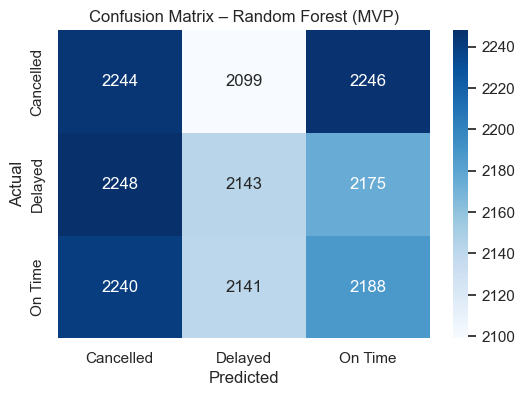

In [17]:
# ==========================================
# Confusion matrix visualization
# ==========================================

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=rf_pipeline.classes_,
    yticklabels=rf_pipeline.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (MVP)")
plt.show()

## Conclusions and Key Insights

### Model Performance Summary
Both Logistic Regression (baseline) and Random Forest (advanced model)
achieved similar performance, with weighted F1-scores close to 0.33.

Despite increased model complexity, Random Forest did not significantly
outperform the baseline model, indicating limited predictive signal
in the available feature set.

### Interpretation
Cross-validation results were stable across folds, confirming that
model behavior is consistent and that performance limitations are
data-driven rather than the result of overfitting or pipeline issues.

The confusion matrix shows relatively uniform predictions across
all flight status categories, further supporting this conclusion.

### Business Implications
These findings highlight that accurate flight status prediction
requires richer operational data, such as weather conditions,
real-time airport congestion, or aircraft-level information.

### Limitations
- Synthetic dataset with limited real-world signal
- Absence of key operational predictors
- No hyperparameter tuning performed in the MVP stage

### Next Steps
- Incorporate additional operational features (e.g., weather data)
- Explore gradient boosting models
- Perform feature importance and model interpretability analysis
